## Описание данных
* `city` – город
* `phone` – основное устройство, которое использует водитель
* `signup_date` – дата регистрации аккаунта (YYYYMMDD)
* `last_trip_date` – дата последней поездки (YYYYMMDD)
* `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
* `avg_rating_by_driver` – средняя оценка поездок водителем
* `vg_rating_of_driver` – средняя оценка поездок водителя
* `surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
* `avg_surge` – средний множитель всплеска за все поездки этого водителя
* `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
* `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
* `weekday_pct` – процент поездок пользователя, совершенных в будние дни

In [41]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2, kruskal, mannwhitneyu
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Проверим, есть ли различия в размерах оттока клиентов в разных городах (churn, city)

In [42]:
df = pd.read_csv('/Users/pavel/Desktop/karpov/7 СТАТИСТИКА/11 churn.csv')
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [43]:
df.shape

(50000, 12)

In [44]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [45]:
df.nunique()

avg_dist                  2908
avg_rating_by_driver        27
avg_rating_of_driver        37
avg_surge                  115
city                         3
last_trip_date             182
phone                        2
signup_date                 31
surge_pct                  367
trips_in_first_30_days      59
luxury_car_user              2
weekday_pct                666
dtype: int64

In [46]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

In [47]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [48]:
df['signup_date'] = (df['last_trip_date'].max() - df['last_trip_date']).dt.days
df['churn'] = df['signup_date'].apply(lambda x: "churn" if x > 30 else 'not churn')
df['churn']

0        not churn
1            churn
2            churn
3        not churn
4            churn
           ...    
49995    not churn
49996        churn
49997        churn
49998        churn
49999        churn
Name: churn, Length: 50000, dtype: object

In [49]:
tab = pd.crosstab(df.churn, df.city)
tab

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not churn,4228,6363,8213


<Axes: xlabel='churn', ylabel='count'>

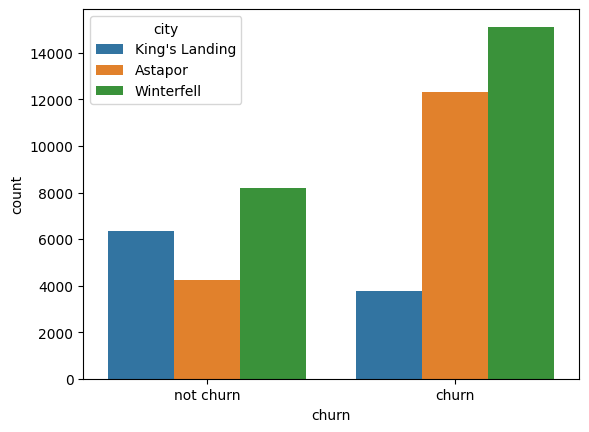

In [50]:
sns.countplot(data = df, x = 'churn', hue = 'city')

In [51]:
stat, p , ddof, expected = chi2_contingency(tab)
stat, p

(3821.5510225559633, 0.0)

Для проверки этой гипотезы я использую `ХИ-КВАДРАТ`, поскольку переменные: `ОБЕ КАТЕГОРИАЛЬНЫЕ`. Нулевая гипотеза `ОТКЛОНЯЕТСЯ`, поскольку `p-value < 0. 05`. Значит, `ВЗАИМОСВЯЗЬ ЕСТЬ`.

Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

<Axes: ylabel='Density'>

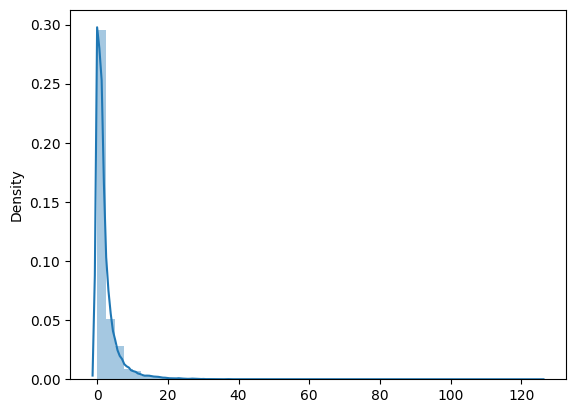

In [52]:
sns.distplot(x = df.trips_in_first_30_days)

In [53]:
Astapor_first_trips = df.query("city == 'Astapor'").trips_in_first_30_days.sample(1000, random_state = 17)
KingsLanding_first_trips = df[df['city'] == "King's Landing"].trips_in_first_30_days.sample(1000, random_state = 17)
Winterfell_first_trips = df.query("city == 'Winterfell'").trips_in_first_30_days.sample(1000, random_state = 17)

In [54]:
ss.shapiro(Astapor_first_trips)

ShapiroResult(statistic=0.5414705276489258, pvalue=4.203895392974451e-45)

In [55]:
ss.shapiro(KingsLanding_first_trips)

ShapiroResult(statistic=0.6132170557975769, pvalue=1.6829594556541053e-42)

In [56]:
ss.shapiro(Winterfell_first_trips)

ShapiroResult(statistic=0.5455788373947144, pvalue=7.006492321624085e-45)

**Распределения не являются нормальными, поэтому используем непараметрический аналог ANOVA – критерий Краскела-Уоллиса**

Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

In [57]:
ss.kruskal(Astapor_first_trips, KingsLanding_first_trips, Winterfell_first_trips)

KruskalResult(statistic=8.51050231028045, pvalue=0.01418952652548608)

Обнаружены статистически значимые различия


Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [58]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,14,15.4,4,True,46.2,not churn
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,57,0.0,0,False,50.0,churn
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,175,0.0,3,False,100.0,churn
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2,20.0,9,True,80.0,not churn
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,108,11.8,14,False,82.4,churn


In [59]:
churn_first_trips = df.query("churn == 'churn'").trips_in_first_30_days.sample(1000, random_state = 17)
not_churn_first_trips = df.query("churn == 'not churn'").trips_in_first_30_days.sample(1000, random_state = 17)

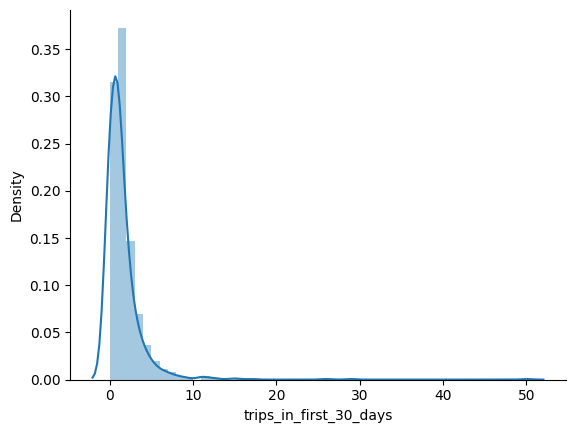

In [60]:
sns.distplot(churn_first_trips)
sns.despine()

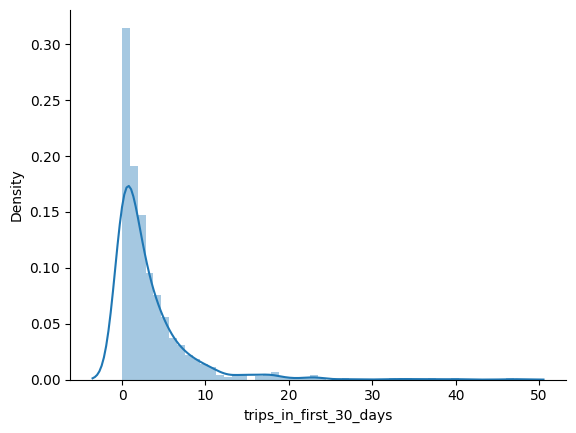

In [61]:
sns.distplot(not_churn_first_trips)
sns.despine()

In [62]:
ss.shapiro(churn_first_trips)

ShapiroResult(statistic=0.456631600856781, pvalue=0.0)

In [63]:
ss.shapiro(not_churn_first_trips)

ShapiroResult(statistic=0.6462708711624146, pvalue=3.391983062744652e-41)

In [75]:
ss.mannwhitneyu(df.query("churn == 'churn'").trips_in_first_30_days, \
                df.query("churn == 'not churn'").trips_in_first_30_days)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

<Axes: xlabel='churn', ylabel='trips_in_first_30_days'>

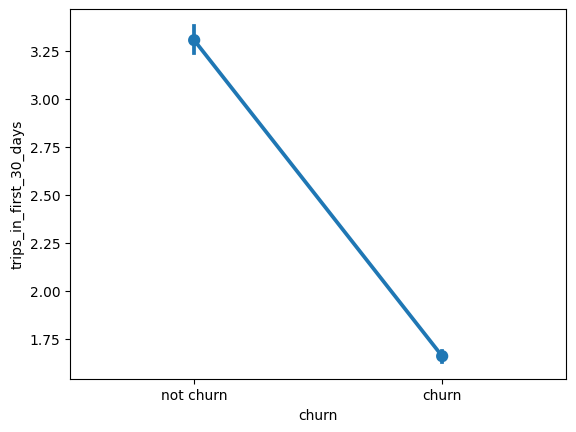

In [28]:
sns.pointplot(data = df, x = 'churn', y = 'trips_in_first_30_days')

Распределение переменной trips_in_first_30_days `НЕ ЯВЛЯЕТСЯ НОРМАЛЬНЫМ`, поэтому для проверки гипотезы я использую `U-КРИТЕРИЙ МАННА-УИТНИ`. Результат оказался статистически `ЗНАЧИМ`. Значит, `ЗНАЧИМЫЕ РАЗЛИЧИЯ ЕСТЬ, УШЕДШИЕ ПОЛЬЗОВАТЕЛИ БЫЛИ МЕНЕЕ АКТИВНЫ`.